# Stratified train/test split for transactions

This notebook reads `dataset/transactions.csv`, sets `X` and `y` (where `y = df["isFraud"]`), and creates a stratified train/test split that preserves the class percentages of `isFraud`.

It prints shapes and class distributions for verification.

In [23]:
# Imports
!pip install xgboost

import os
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, confusion_matrix

# Path to CSV (relative to this notebook)
csv_path = 'dataset/transactions'

if not os.path.exists(csv_path):
    raise FileNotFoundError(f'File not found: {csv_path} - make sure you run the notebook from the repository root or adjust the path.')

# Read the dataset
df = pd.read_csv(csv_path)
print('Loaded dataset with shape:', df.shape)

# Drop all null columns
# AccountNumber and customerId are duplicated
# TransactionDateTime has no impact on fraud detection (evenly distributed both fraudulent and non-fraudulent)
df = df.drop(["Unnamed: 0", "customerId", "echoBuffer", "merchantCity", "merchantState", "merchantZip", "posOnPremises", "recurringAuthInd"], axis=1)

df.head()
df.info()
df.nunique()

Loaded dataset with shape: (786363, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   creditLimit               786363 non-null  int64  
 2   availableMoney            786363 non-null  float64
 3   transactionDateTime       786363 non-null  object 
 4   transactionAmount         786363 non-null  float64
 5   merchantName              786363 non-null  object 
 6   acqCountry                781801 non-null  object 
 7   merchantCountryCode       785639 non-null  object 
 8   posEntryMode              782309 non-null  float64
 9   posConditionCode          785954 non-null  float64
 10  merchantCategoryCode      786363 non-null  object 
 11  currentExpDate            786363 non-null  object 
 12  accountOpenDate           786363 non-null  object 
 13  date

accountNumber                 5000
creditLimit                     10
availableMoney              521861
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       4
merchantCountryCode              4
posEntryMode                     5
posConditionCode                 3
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  3
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
dtype: int64

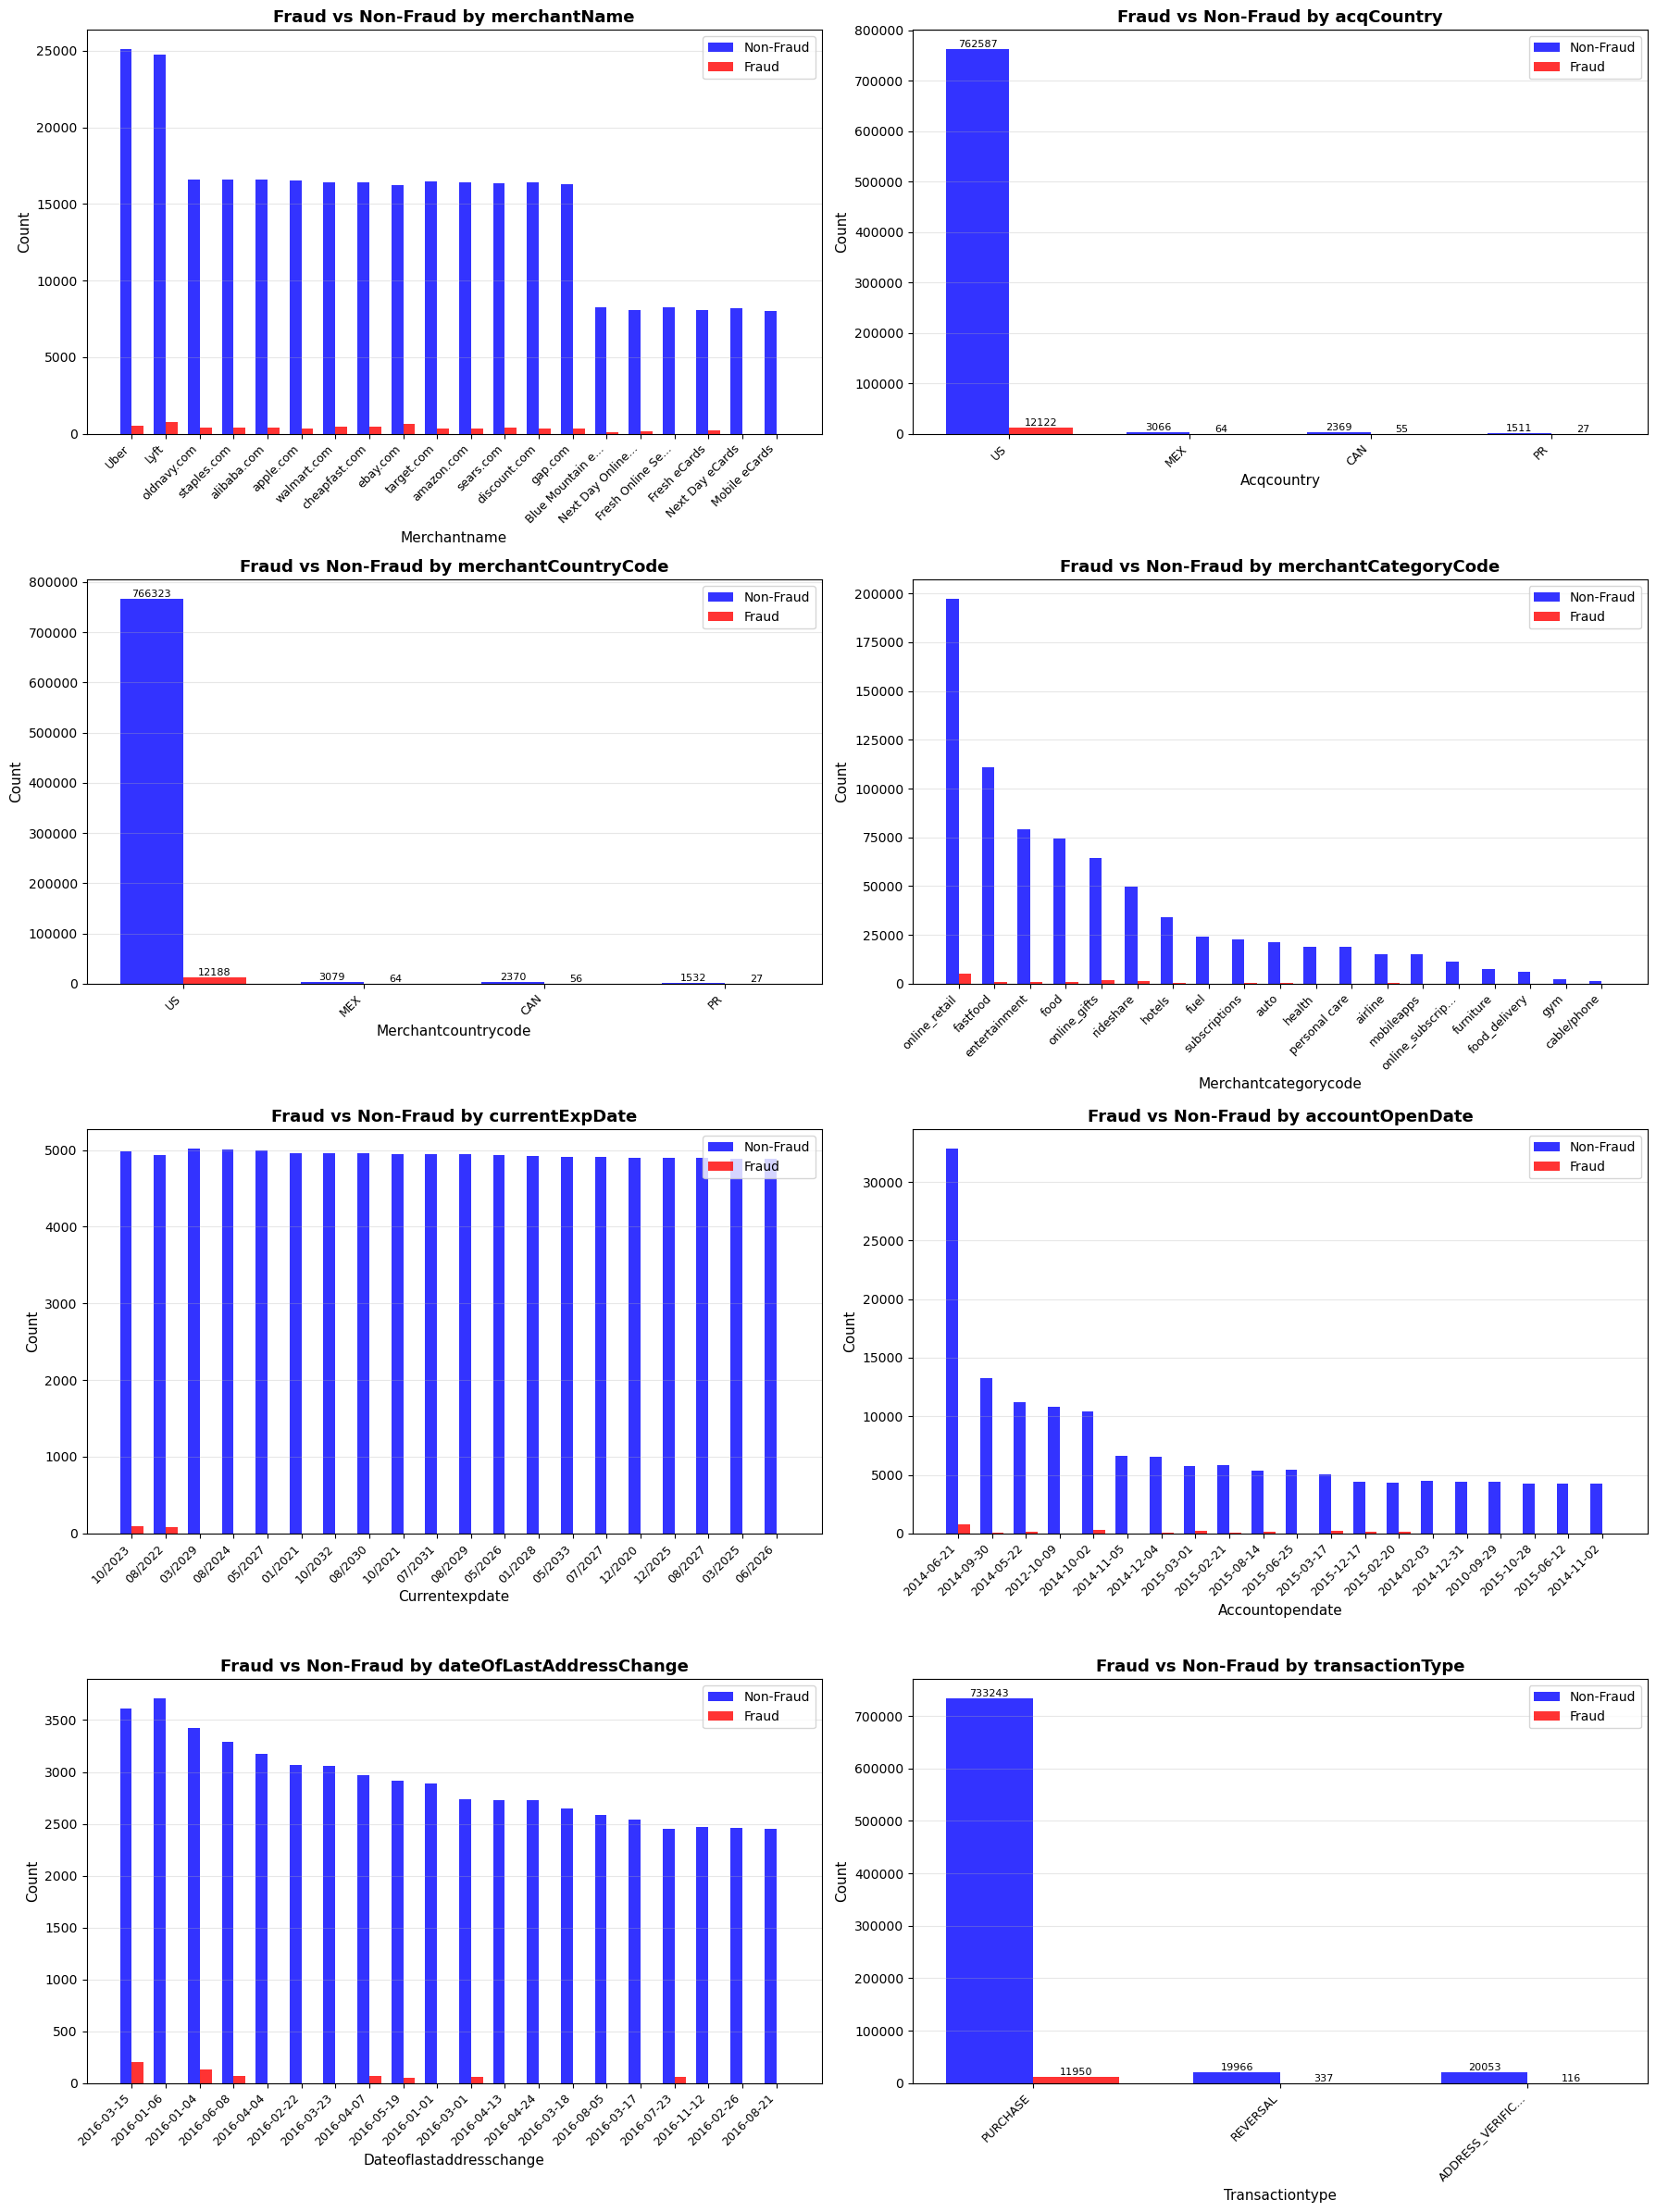


Plots generated successfully!

Showing top 20 categories for each feature (by total count)

merchantName:
  Total unique values: 2490
  Unique in fraud: 1042
  Unique in non-fraud: 2490

acqCountry:
  Total unique values: 4
  Unique in fraud: 4
  Unique in non-fraud: 4

merchantCountryCode:
  Total unique values: 4
  Unique in fraud: 4
  Unique in non-fraud: 4

merchantCategoryCode:
  Total unique values: 19
  Unique in fraud: 13
  Unique in non-fraud: 19

currentExpDate:
  Total unique values: 165
  Unique in fraud: 165
  Unique in non-fraud: 165

accountOpenDate:
  Total unique values: 1820
  Unique in fraud: 1184
  Unique in non-fraud: 1820

dateOfLastAddressChange:
  Total unique values: 2184
  Unique in fraud: 1447
  Unique in non-fraud: 2184

transactionType:
  Total unique values: 3
  Unique in fraud: 3
  Unique in non-fraud: 3


In [24]:
# Plot fraud vs non-fraud for categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = [
    'merchantName', 
    'acqCountry', 
    'merchantCountryCode', 
    'merchantCategoryCode',
    'currentExpDate', 
    'accountOpenDate', 
    'dateOfLastAddressChange', 
    'transactionType'
]

# Create subplots - 4 rows x 2 columns
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    
    # Check if column exists
    if feature not in df.columns:
        ax.text(0.5, 0.5, f'{feature} not found in dataset', 
                ha='center', va='center', fontsize=12)
        ax.set_title(f'{feature} - NOT FOUND', fontsize=14, fontweight='bold')
        continue
    
    # Count fraud and non-fraud for each unique value
    fraud_counts = df[df['isFraud'] == 1][feature].value_counts().sort_values(ascending=False).head(20)
    non_fraud_counts = df[df['isFraud'] == 0][feature].value_counts().sort_values(ascending=False).head(20)
    
    # Get union of top categories from both
    all_categories = list(set(fraud_counts.index) | set(non_fraud_counts.index))
    all_categories = sorted(all_categories, 
                           key=lambda x: fraud_counts.get(x, 0) + non_fraud_counts.get(x, 0), 
                           reverse=True)[:20]
    
    # Combine into a dataframe for plotting
    plot_df = pd.DataFrame({
        'Fraud': [fraud_counts.get(cat, 0) for cat in all_categories],
        'Non-Fraud': [non_fraud_counts.get(cat, 0) for cat in all_categories]
    }, index=all_categories)
    
    # Create bar plot
    x_pos = range(len(plot_df.index))
    width = 0.35
    
    ax.bar([x - width/2 for x in x_pos], plot_df['Non-Fraud'], width, 
           label='Non-Fraud', alpha=0.8, color='blue')
    ax.bar([x + width/2 for x in x_pos], plot_df['Fraud'], width, 
           label='Fraud', alpha=0.8, color='red')
    
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'Fraud vs Non-Fraud by {feature}', fontsize=13, fontweight='bold')
    ax.set_xticks(x_pos)
    
    # Rotate labels for readability
    labels = [str(label)[:15] + '...' if len(str(label)) > 15 else str(label) 
              for label in plot_df.index]
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Add counts on top if there aren't too many bars
    if len(plot_df.index) <= 10:
        for i, (nf, f) in enumerate(zip(plot_df['Non-Fraud'], plot_df['Fraud'])):
            if nf > 0:
                ax.text(i - width/2, nf, int(nf), ha='center', va='bottom', fontsize=8)
            if f > 0:
                ax.text(i + width/2, f, int(f), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print('\nPlots generated successfully!')
print(f'\nShowing top 20 categories for each feature (by total count)')

# Print some statistics
for feature in categorical_features:
    if feature in df.columns:
        total_unique = df[feature].nunique()
        fraud_unique = df[df['isFraud'] == 1][feature].nunique()
        non_fraud_unique = df[df['isFraud'] == 0][feature].nunique()
        print(f'\n{feature}:')
        print(f'  Total unique values: {total_unique}')
        print(f'  Unique in fraud: {fraud_unique}')
        print(f'  Unique in non-fraud: {non_fraud_unique}')


In [25]:
# One-hot encoding for categorical columns
print('Starting one-hot encoding...\n')

# Columns to encode
columns_with_nulls = ['acqCountry', 'merchantCountryCode', 'transactionType']
columns_without_nulls = ['merchantCategoryCode']
all_encode_columns = columns_with_nulls + columns_without_nulls

# Check which columns exist and their null counts
print('Checking columns and null values:')
for col in all_encode_columns:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        unique_count = df[col].nunique()
        print(f'  {col}: {null_count} nulls, {unique_count} unique values')
    else:
        print(f'  {col}: NOT FOUND in dataset')

print('\n' + '='*60)

# Handle columns with nulls - create indicator columns and fill nulls
for col in columns_with_nulls:
    if col in df.columns:
        # Create indicator column for null values
        null_indicator_col = f'no{col}'
        df[null_indicator_col] = df[col].isnull().astype(int)
        
        null_count = df[col].isnull().sum()
        print(f'\nCreated {null_indicator_col}: {null_count} entries with missing {col}')
        
        # Fill nulls with a placeholder for encoding
        df[col] = df[col].fillna('MISSING')

# Perform one-hot encoding
print('\n' + '='*60)
print('\nApplying one-hot encoding...\n')

encoded_dfs = []
original_shape = df.shape

for col in all_encode_columns:
    if col in df.columns:
        # Get one-hot encoding
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=False)
        
        # For columns with nulls, drop the MISSING category column since we already have no[column_name]
        if col in columns_with_nulls:
            missing_col_name = f'{col}_MISSING'
            if missing_col_name in one_hot.columns:
                one_hot = one_hot.drop(columns=[missing_col_name])
                print(f'{col}: {len(one_hot.columns)} new columns created (dropped {missing_col_name} - using no{col} instead)')
            else:
                print(f'{col}: {len(one_hot.columns)} new columns created')
        else:
            print(f'{col}: {len(one_hot.columns)} new columns created')
        
        print(f'  Sample columns: {list(one_hot.columns[:5])}...')
        
        encoded_dfs.append(one_hot)
        
        # Drop the original column
        df = df.drop(columns=[col])

# Concatenate all encoded columns
if encoded_dfs:
    df = pd.concat([df] + encoded_dfs, axis=1)

print('\n' + '='*60)
print(f'\nEncoding complete!')
print(f'Original shape: {original_shape}')
print(f'New shape: {df.shape}')
print(f'Columns added: {df.shape[1] - original_shape[1]}')

# Show summary of null indicator columns
print('\nNull indicator columns created:')
for col in columns_with_nulls:
    null_indicator_col = f'no{col}'
    if null_indicator_col in df.columns:
        count = df[null_indicator_col].sum()
        pct = (count / len(df)) * 100
        print(f'  {null_indicator_col}: {int(count)} entries ({pct:.2f}%)')

print('\nDataframe info after encoding:')
df.info()


Starting one-hot encoding...

Checking columns and null values:
  acqCountry: 4562 nulls, 4 unique values
  merchantCountryCode: 724 nulls, 4 unique values
  transactionType: 698 nulls, 3 unique values
  merchantCategoryCode: 0 nulls, 19 unique values


Created noacqCountry: 4562 entries with missing acqCountry

Created nomerchantCountryCode: 724 entries with missing merchantCountryCode

Created notransactionType: 698 entries with missing transactionType


Applying one-hot encoding...

acqCountry: 4 new columns created (dropped acqCountry_MISSING - using noacqCountry instead)
  Sample columns: ['acqCountry_CAN', 'acqCountry_MEX', 'acqCountry_PR', 'acqCountry_US']...
merchantCountryCode: 4 new columns created (dropped merchantCountryCode_MISSING - using nomerchantCountryCode instead)
  Sample columns: ['merchantCountryCode_CAN', 'merchantCountryCode_MEX', 'merchantCountryCode_PR', 'merchantCountryCode_US']...
transactionType: 3 new columns created (dropped transactionType_MISSING - usin

In [26]:
# Convert date columns to days since transaction
print('Converting date columns to numeric features (days difference)...\n')

# Date columns to convert
date_columns = {
    'currentExpDate': 'daysToCurrentExpDate',
    'accountOpenDate': 'daysSinceAccountOpen',
    'dateOfLastAddressChange': 'daysSinceLastAddressChange'
}

# Convert transactionDateTime to datetime if not already
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], errors='coerce')

print('Processing date columns:')
print(f'Reference date column: transactionDateTime')
print(f'  Sample values: {df["transactionDateTime"].head(3).tolist()}\n')

for original_col, new_col in date_columns.items():
    if original_col in df.columns:
        print(f'\nProcessing {original_col} -> {new_col}')
        
        # Convert to datetime
        df[original_col] = pd.to_datetime(df[original_col], errors='coerce')
        
        # Count nulls before calculation
        nulls_before = df[original_col].isnull().sum()
        print(f'  Null values: {nulls_before}')
        
        # Calculate difference in days (transactionDateTime - original_col)
        # Positive values = date is before transaction (past)
        # Negative values = date is after transaction (future, like expiration dates)
        df[new_col] = (df['transactionDateTime'] - df[original_col]).dt.days

        if new_col == "daysToCurrentExpDate":
            df[new_col] = -df[new_col]
        
        # Check statistics
        nulls_after = df[new_col].isnull().sum()
        valid_count = df[new_col].notna().sum()
        
        if valid_count > 0:
            min_val = df[new_col].min()
            max_val = df[new_col].max()
            mean_val = df[new_col].mean()
            median_val = df[new_col].median()
            
            print(f'  Statistics for {new_col}:')
            print(f'    Valid entries: {valid_count}')
            print(f'    Null entries after conversion: {nulls_after}')
            print(f'    Min: {min_val:.0f} days')
            print(f'    Max: {max_val:.0f} days')
            print(f'    Mean: {mean_val:.2f} days')
            print(f'    Median: {median_val:.0f} days')
            
            # Show sample values
            sample_df = df[[original_col, 'transactionDateTime', new_col]].dropna().head(3)
            if len(sample_df) > 0:
                print(f'    Sample calculations:')
                for idx, row in sample_df.iterrows():
                    print(f'      {row[original_col].date()} -> {row["transactionDateTime"].date()} = {int(row[new_col])} days')
        
        # Drop the original date column
        df = df.drop(columns=[original_col])
        print(f'  Dropped original column: {original_col}')
    else:
        print(f'\n{original_col}: NOT FOUND in dataset - skipping')

print('\n' + '='*60)
print('\nDate conversion complete!')
print(f'New columns created: {list(date_columns.values())}')
print(f'Current dataframe shape: {df.shape}')

# Show data types of new columns
print('\nNew column data types:')
for new_col in date_columns.values():
    if new_col in df.columns:
        print(f'  {new_col}: {df[new_col].dtype}')

df.drop(['transactionDateTime'], axis=1, inplace=True)

print('\nDataframe info after date conversion:')
df.info()


Converting date columns to numeric features (days difference)...

Processing date columns:
Reference date column: transactionDateTime
  Sample values: [Timestamp('2016-08-13 14:27:32'), Timestamp('2016-10-11 05:05:54'), Timestamp('2016-11-08 09:18:39')]


Processing currentExpDate -> daysToCurrentExpDate
  Null values: 0
  Statistics for daysToCurrentExpDate:
    Valid entries: 786363
    Null entries after conversion: 0
    Min: 1066 days
    Max: 6422 days
    Mean: 3734.41 days
    Median: 3739 days
    Sample calculations:
      2023-06-01 -> 2016-08-13 = 2483 days
      2024-02-01 -> 2016-10-11 = 2669 days
      2025-08-01 -> 2016-11-08 = 3188 days


C:\Users\Marina\AppData\Local\Temp\ipykernel_4660\2053595668.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[original_col] = pd.to_datetime(df[original_col], errors='coerce')


  Dropped original column: currentExpDate

Processing accountOpenDate -> daysSinceAccountOpen
  Null values: 0
  Statistics for daysSinceAccountOpen:
    Valid entries: 786363
    Null entries after conversion: 0
    Min: 1 days
    Max: 9990 days
    Mean: 883.53 days
    Median: 680 days
    Sample calculations:
      2015-03-14 -> 2016-08-13 = 518 days
      2015-03-14 -> 2016-10-11 = 577 days
      2015-03-14 -> 2016-11-08 = 605 days
  Dropped original column: accountOpenDate

Processing dateOfLastAddressChange -> daysSinceLastAddressChange
  Null values: 0
  Statistics for daysSinceLastAddressChange:
    Valid entries: 786363
    Null entries after conversion: 0
    Min: 0 days
    Max: 9990 days
    Mean: 448.30 days
    Median: 159 days
    Sample calculations:
      2015-03-14 -> 2016-08-13 = 518 days
      2015-03-14 -> 2016-10-11 = 577 days
      2015-03-14 -> 2016-11-08 = 605 days
  Dropped original column: dateOfLastAddressChange


Date conversion complete!
New columns crea

In [27]:
# Apply ordinal encoding to merchantName based on custom scoring
import numpy as np

print('Applying ordinal encoding to merchantName...\n')

if 'merchantName' not in df.columns:
    print('merchantName column not found in dataset - skipping')
else:
    # Calculate statistics for each merchant
    merchant_stats = df.groupby('merchantName').agg({
        'isFraud': ['sum', 'count']  # sum of fraud, total count
    }).reset_index()
    
    merchant_stats.columns = ['merchantName', 'fraud_count', 'total_count']
    
    # Calculate probability of non-fraud
    merchant_stats['prob_non_fraud'] = (merchant_stats['total_count'] - merchant_stats['fraud_count']) / merchant_stats['total_count']
    
    # Calculate score: probability of non-fraud * log(num of transactions)
    merchant_stats['score'] = merchant_stats['prob_non_fraud'] * np.log(merchant_stats['total_count'])
    
    # Sort by score (ascending) and assign ordinal ranks (0, 1, 2, ...)
    merchant_stats = merchant_stats.sort_values('score', ascending=True).reset_index(drop=True)
    merchant_stats['ordinal_rank'] = range(len(merchant_stats))
    
    print(f'Total unique merchants: {len(merchant_stats)}')
    print(f'\nTop 10 merchants with LOWEST scores (most risky):')
    print(merchant_stats[['merchantName', 'fraud_count', 'total_count', 'prob_non_fraud', 'score', 'ordinal_rank']].head(10))
    print(f'\nTop 10 merchants with HIGHEST scores (least risky):')
    print(merchant_stats[['merchantName', 'fraud_count', 'total_count', 'prob_non_fraud', 'score', 'ordinal_rank']].tail(10))
    
    # Create mapping dictionary
    merchant_to_rank = dict(zip(merchant_stats['merchantName'], merchant_stats['ordinal_rank']))
    
    # Apply ordinal encoding
    df['merchantName_ordinal'] = df['merchantName'].map(merchant_to_rank)
    
    # Check for any unmapped values (shouldn't happen but good to verify)
    unmapped_count = df['merchantName_ordinal'].isnull().sum()
    if unmapped_count > 0:
        print(f'\nWarning: {unmapped_count} merchants could not be mapped (assigning median rank)')
        median_rank = merchant_stats['ordinal_rank'].median()
        df['merchantName_ordinal'].fillna(median_rank, inplace=True)
    
    # Drop original merchantName column
    df = df.drop(columns=['merchantName'])
    
    print('\n' + '='*60)
    print('\nOrdinal encoding complete!')
    print(f'New column created: merchantName_ordinal')
    print(f'Encoding range: {df["merchantName_ordinal"].min():.0f} to {df["merchantName_ordinal"].max():.0f}')
    print(f'Mean ordinal value: {df["merchantName_ordinal"].mean():.2f}')
    print(f'Median ordinal value: {df["merchantName_ordinal"].median():.0f}')
    
    # Show distribution statistics
    print('\nOrdinal value distribution:')
    print(df['merchantName_ordinal'].describe())
    
    print(f'\nCurrent dataframe shape: {df.shape}')
    
print('\nDataframe info after merchantName encoding:')
df.info()


Applying ordinal encoding to merchantName...

Total unique merchants: 2490

Top 10 merchants with LOWEST scores (most risky):
                    merchantName  fraud_count  total_count  prob_non_fraud  \
0            EZ Wireless #149871            0            1             1.0   
1       TMobile Wireless #602341            0            1             1.0   
2                 Curves #849125            0            1             1.0   
3              Golds Gym #956354            0            2             1.0   
4           Boost Mobile #104815            0            2             1.0   
5                Runners #383214            0            2             1.0   
6  Sprint Communications #561941            0            2             1.0   
7              Golds Gym #970513            0            3             1.0   
8  Sprint Communications #557203            0            3             1.0   
9  Sprint Communications #606030            0            3             1.0   

      score  or

Creating correlation matrices...


1. PEARSON CORRELATION MATRIX

Pearson correlation matrix shape: (50, 50)
Number of features: 50

Top 15 features most correlated with isFraud (Pearson):
transactionAmount                            0.075651
cardPresent                                  0.043418
merchantCategoryCode_online_retail           0.040752
merchantName_ordinal                         0.028732
nomerchantCountryCode                        0.023735
merchantCategoryCode_fuel                    0.022430
merchantCategoryCode_airline                 0.021388
merchantCategoryCode_online_gifts            0.020571
merchantCategoryCode_fastfood                0.020325
merchantCategoryCode_rideshare               0.019218
merchantCategoryCode_mobileapps              0.017657
merchantCategoryCode_online_subscriptions    0.015133
merchantCategoryCode_hotels                  0.014445
merchantCategoryCode_personal care           0.014193
merchantCategoryCode_health                  0.014016
N

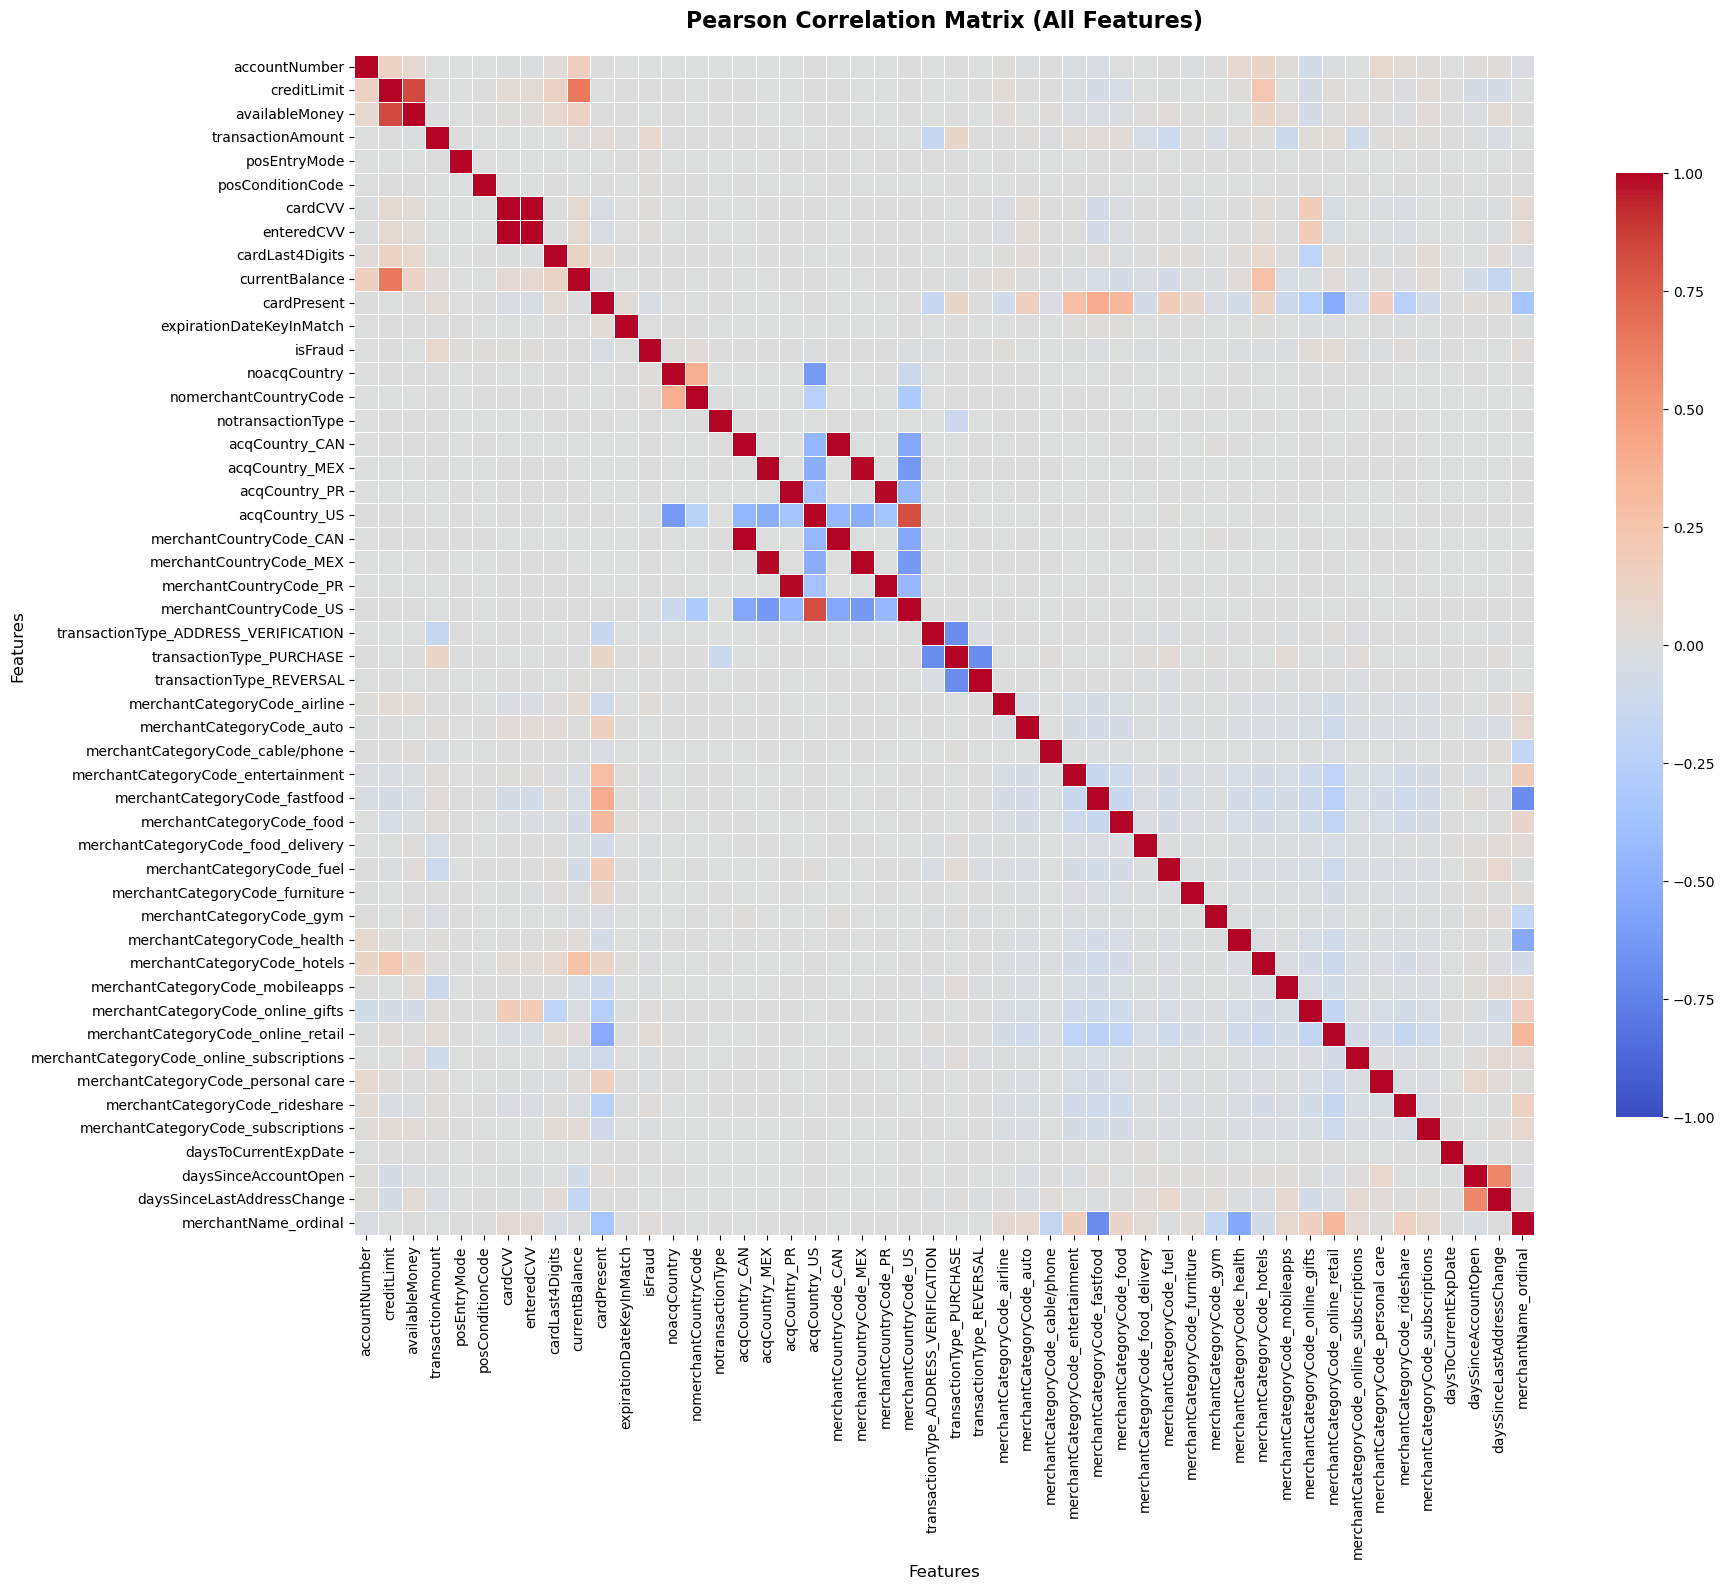


2. CHI-SQUARED ASSOCIATION MATRIX

Calculating Chi-squared statistics for 49 features...

Top 15 features by Chi-squared score (association with isFraud):
                                  Feature  Chi2_Score       P_Value
       merchantCategoryCode_online_retail  970.190803 5.417624e-213
                              cardPresent  817.185692 9.899916e-180
                    nomerchantCountryCode  442.580857  2.969997e-98
                merchantCategoryCode_fuel  383.606182  2.041025e-85
                        transactionAmount  356.417136  1.697278e-79
             merchantCategoryCode_airline  352.667024  1.112663e-78
        merchantCategoryCode_online_gifts  304.721382  3.084378e-68
            merchantCategoryCode_fastfood  278.525447  1.573728e-62
           merchantCategoryCode_rideshare  271.544213  5.228273e-61
          merchantCategoryCode_mobileapps  240.495887  3.066058e-54
merchantCategoryCode_online_subscriptions  177.556236  1.655819e-40
              merchantCatego

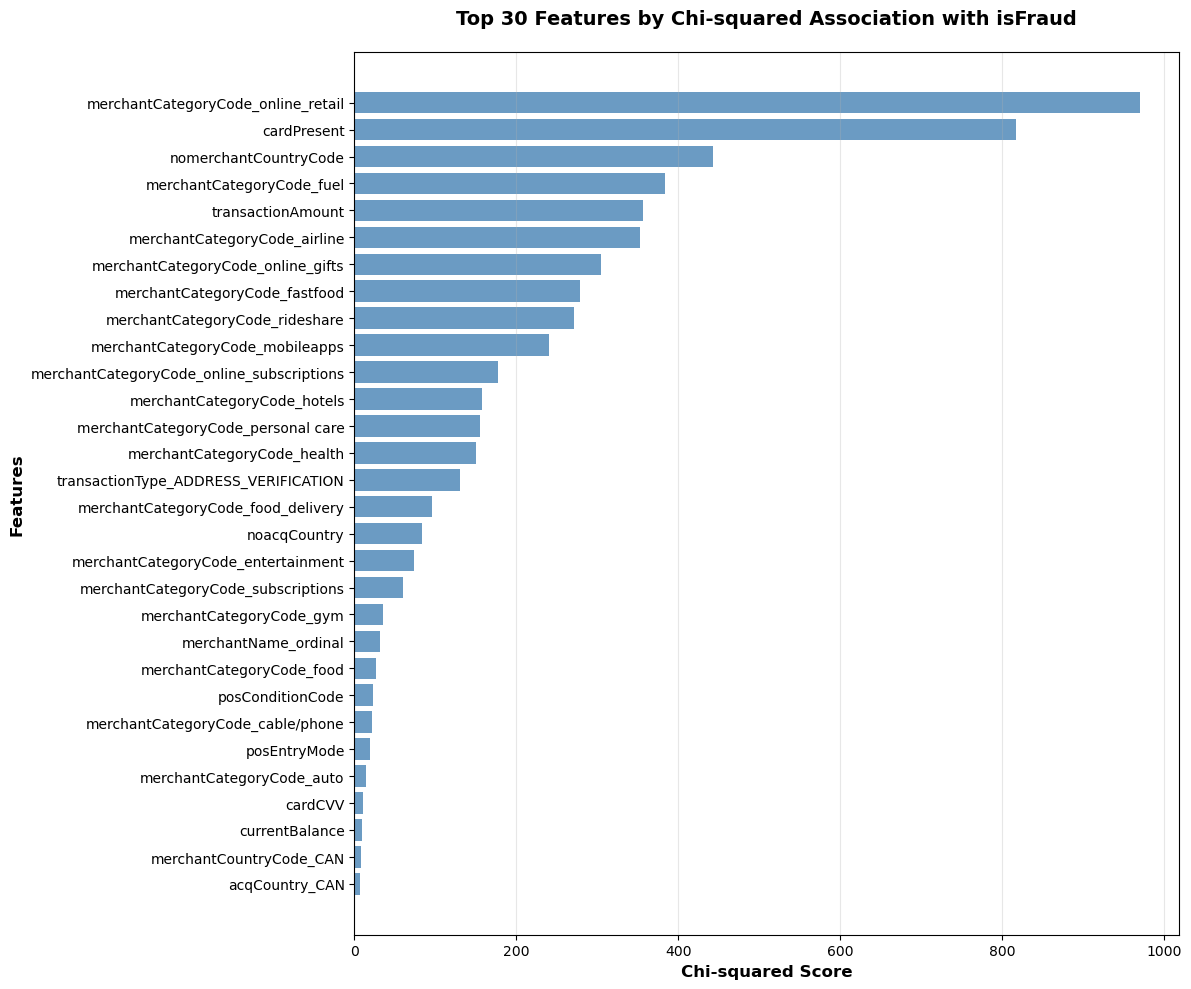

C:\Users\Marina\AppData\Local\Temp\ipykernel_4660\3990486980.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


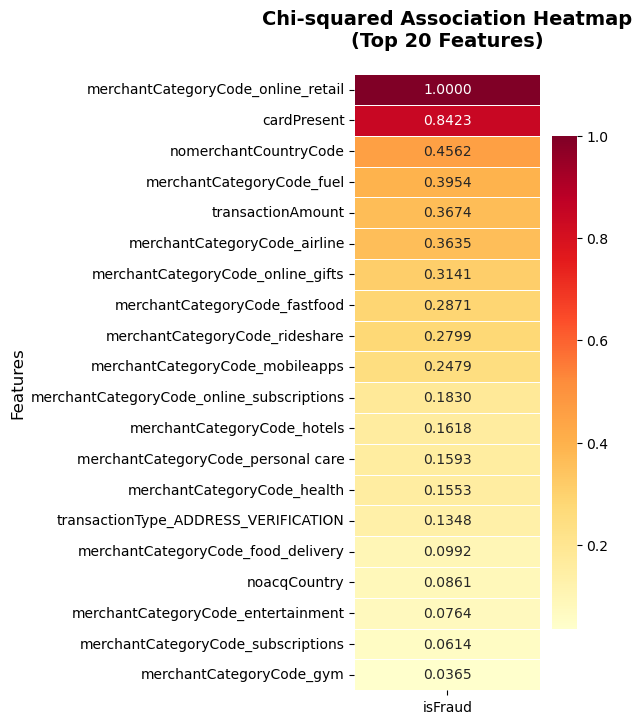


Correlation analysis complete!


In [28]:
# Create correlation matrices - Pearson and Chi-squared
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

print('Creating correlation matrices...\n')
print('='*60)

# ==============================================================================
# 1. PEARSON CORRELATION MATRIX
# ==============================================================================
print('\n1. PEARSON CORRELATION MATRIX')
print('='*60)

# Calculate Pearson correlation for all numeric columns
pearson_corr = df.corr(method='pearson')

print(f'\nPearson correlation matrix shape: {pearson_corr.shape}')
print(f'Number of features: {len(pearson_corr.columns)}')

# Find top correlations with isFraud
if 'isFraud' in pearson_corr.columns:
    fraud_corr = pearson_corr['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
    print(f'\nTop 15 features most correlated with isFraud (Pearson):')
    print(fraud_corr.head(15))

# Create visualization for Pearson correlation
plt.figure(figsize=(20, 16))

# If too many features, show only top correlations with isFraud
if len(pearson_corr.columns) > 50:
    # Select top features correlated with isFraud
    top_features = fraud_corr.head(30).index.tolist()
    if 'isFraud' not in top_features:
        top_features.append('isFraud')
    
    pearson_subset = pearson_corr.loc[top_features, top_features]
    
    sns.heatmap(pearson_subset, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1)
    plt.title(f'Pearson Correlation Matrix (Top 30 features + isFraud)', fontsize=16, fontweight='bold', pad=20)
    print(f'\nShowing top 30 features most correlated with isFraud (matrix too large: {len(pearson_corr.columns)} features)')
else:
    sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1)
    plt.title('Pearson Correlation Matrix (All Features)', fontsize=16, fontweight='bold', pad=20)

plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# ==============================================================================
# 2. CHI-SQUARED CORRELATION MATRIX
# ==============================================================================
print('\n' + '='*60)
print('2. CHI-SQUARED ASSOCIATION MATRIX')
print('='*60)

# Chi-squared requires non-negative values
# Scale features to [0, 1] range
df_chi = df.copy()

# Separate features and target
if 'isFraud' in df_chi.columns:
    X_chi = df_chi.drop(columns=['isFraud'])
    y_chi = df_chi['isFraud']
    
    # Handle any NaN values
    X_chi = X_chi.fillna(X_chi.median())
    
    # Scale to non-negative range [0, 1]
    scaler = MinMaxScaler()
    X_chi_scaled = scaler.fit_transform(X_chi)
    X_chi_scaled_df = pd.DataFrame(X_chi_scaled, columns=X_chi.columns)
    
    print(f'\nCalculating Chi-squared statistics for {len(X_chi.columns)} features...')
    
    # Calculate chi-squared statistics
    chi2_scores, p_values = chi2(X_chi_scaled_df, y_chi)
    
    # Create a dataframe with results
    chi2_df = pd.DataFrame({
        'Feature': X_chi.columns,
        'Chi2_Score': chi2_scores,
        'P_Value': p_values
    }).sort_values('Chi2_Score', ascending=False)
    
    print(f'\nTop 15 features by Chi-squared score (association with isFraud):')
    print(chi2_df.head(15).to_string(index=False))
    
    # Create a correlation-like matrix using normalized chi-squared scores
    # Normalize chi2 scores to [0, 1] range for visualization
    chi2_normalized = chi2_scores / chi2_scores.max() if chi2_scores.max() > 0 else chi2_scores
    
    # Create a simple association matrix (features vs isFraud)
    chi2_matrix = pd.DataFrame({
        'isFraud_Association': chi2_normalized
    }, index=X_chi.columns)
    
    # Visualize Chi-squared associations
    plt.figure(figsize=(12, max(10, len(chi2_df.head(30)) * 0.3)))
    
    top_n = min(30, len(chi2_df))
    top_chi2 = chi2_df.head(top_n)
    
    # Create horizontal bar plot
    plt.barh(range(len(top_chi2)), top_chi2['Chi2_Score'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_chi2)), top_chi2['Feature'], fontsize=10)
    plt.xlabel('Chi-squared Score', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features by Chi-squared Association with isFraud', 
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Additional heatmap for top features
    plt.figure(figsize=(3, max(8, len(top_chi2.head(20)) * 0.4)))
    
    top_20_features = top_chi2.head(20)['Feature'].tolist()
    chi2_heatmap_data = chi2_matrix.loc[top_20_features].values.reshape(-1, 1)
    
    sns.heatmap(chi2_heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd',
                yticklabels=top_20_features, xticklabels=['isFraud'],
                cbar_kws={"shrink": 0.8}, linewidths=0.5)
    plt.title('Chi-squared Association Heatmap\n(Top 20 Features)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()
    
else:
    print('\nisFraud column not found - skipping Chi-squared analysis')

print('\n' + '='*60)
print('Correlation analysis complete!')
print('='*60)


In [29]:
# Prepare X and y
if 'isFraud' not in df.columns:
    raise KeyError(
        "Column 'isFraud' not found in dataframe. Check the CSV or column name casing."
    )

y = df['isFraud']
X = df.drop(columns=['isFraud'])

print('X shape:', X.shape)
print('y shape:', y.shape)

# Overall class distribution (percentage)
print('Overall class distribution (%):')
print((y.value_counts(normalize=True) * 100).round(4))

X shape: (786363, 49)
y shape: (786363,)
Overall class distribution (%):
isFraud
False    98.421
True      1.579
Name: proportion, dtype: float64


In [30]:
# Stratified train/test split
# Keep class proportions by using `stratify=y`
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train shapes -> X:', X_train.shape, 'y:', y_train.shape)
print('Test shapes  -> X:', X_test.shape, 'y:', y_test.shape)

print('Train class distribution (%):')
print((y_train.value_counts(normalize=True) * 100).round(4))

print('Test class distribution (%):')
print((y_test.value_counts(normalize=True) * 100).round(4))

Train shapes -> X: (629090, 49) y: (629090,)
Test shapes  -> X: (157273, 49) y: (157273,)
Train class distribution (%):
isFraud
False    98.4209
True      1.5791
Name: proportion, dtype: float64
Test class distribution (%):
isFraud
False    98.4212
True      1.5788
Name: proportion, dtype: float64


In [31]:
# Quick numeric check that proportions are close to overall proportions
print('Per-class proportions (overall vs train vs test):')
for cls in sorted(y.unique()):
    overall = (y == cls).mean()
    train = (y_train == cls).mean()
    test = (y_test == cls).mean()
    print(f'Class {cls}: overall={overall:.6f}, train={train:.6f}, test={test:.6f}')

# Optional: save the splits (uncomment to write)
# X_train.to_csv('dataset/X_train.csv', index=False)
# X_test.to_csv('dataset/X_test.csv', index=False)
# y_train.to_csv('dataset/y_train.csv', index=False)
# y_test.to_csv('dataset/y_test.csv', index=False)

print('Done. If you want the splits written to disk, uncomment the save lines above.')

Per-class proportions (overall vs train vs test):
Class False: overall=0.984210, train=0.984209, test=0.984212
Class True: overall=0.015790, train=0.015791, test=0.015788
Done. If you want the splits written to disk, uncomment the save lines above.


In [ ]:
# Train XGBoost with focus on recall
# Calculate scale_pos_weight to handle class imbalance (improves recall for minority class)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1

print(f'Class imbalance ratio (neg/pos): {scale_pos_weight:.2f}')
print(f'Using scale_pos_weight={scale_pos_weight:.2f} to boost recall for fraud class\n')

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# # X_train și y_train sunt datele numai de antrenare, separat de test!
# smote = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train, y_train = X_train_resampled, y_train_resampled

# # Create XGBoost model optimized for recall
# # - scale_pos_weight: handles class imbalance
# # - max_depth: controls tree depth (lower = simpler, higher = more complex)
# # - learning_rate: step size (lower = slower but more precise)
# model = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='aucpr',  
#     max_depth=6,
#     scale_pos_weight=scale_pos_weight,
#     learning_rate=0.1,
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1
# )

# print('Training XGBoost model...')
# model.fit(X_train, y_train)
# print('Training complete!\n')

# Predictions on train set
# y_train_pred = model.predict(X_train)
# print('=== TRAIN SET PERFORMANCE ===')
# print(f'Recall (fraud class): {recall_score(y_train, y_train_pred):.4f}')
# print(f'Precision (fraud class): {precision_score(y_train, y_train_pred):.4f}')
# print(f'F1-Score (fraud class): {f1_score(y_train, y_train_pred):.4f}')
# print('\nConfusion Matrix (Train):')
# print(confusion_matrix(y_train, y_train_pred))
# print('\nClassification Report (Train):')
# print(classification_report(y_train, y_train_pred))

# 3. Pipeline: SMOTE + ENN + ADASYN + XGBoost
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.over_sampling import SMOTE, ADASYN
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=0)),
    ('enn', ENN(n_neighbors=3)),
    ('adasyn', ADASYN(sampling_strategy='auto', random_state=0)),
    ('xgb', XGBClassifier(
        scale_pos_weight=100,  # ajustat in functie de dezechilibru
        eval_metric="aucpr",
        use_label_encoder=False
    ))
])

# 4. Train
pipeline.fit(X_train, y_train)

# 5. Predict & Evaluate
y_pred = pipeline.predict(X_test)

y_test_pred = y_pred

# Predictions on test set
# y_test_pred = model.predict(X_test)
print('\n=== TEST SET PERFORMANCE ===')
print(f'Recall (fraud class): {recall_score(y_test, y_test_pred):.4f}')
print(f'Precision (fraud class): {precision_score(y_test, y_test_pred):.4f}')
print(f'F1-Score (fraud class): {f1_score(y_test, y_test_pred):.4f}')
print('\nConfusion Matrix (Test):')
print(confusion_matrix(y_test, y_test_pred))
print('\nClassification Report (Test):')
print(classification_report(y_test, y_test_pred))

# # Feature importances
# if hasattr(X_train, 'columns'):
#     import pandas as _pd
#     fi = _pd.Series(model.feature_importances_, index=X_train.columns)
#     print('\nTop 10 Most Important Features:')
#     print(fi.nlargest(10))


Class imbalance ratio (neg/pos): 0.92
Using scale_pos_weight=0.92 to boost recall for fraud class

